# Synthetic Audio Detector

Building a Synthetic Audio Detector using Convolutional Neural Networks.

The dataset used is the 2 seconds version of the [Fake or Real (FoR)](https://www.kaggle.com/datasets/mohammedabdeldayem/the-fake-or-real-dataset?resource=download-directory) dataset which aggregates real and synthetic audio from various sources. You can read more about it on the Kaggle dataset page.

## Environment Setup

In [1]:
#Imports
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import joblib
import json

2025-04-02 11:55:29.972332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 11:55:29.981931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743594929.992164   14979 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743594929.995477   14979 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743594930.003821   14979 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
#Setting seed
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#Setting constants
DATASET_PATH = 'dataset'
SAMPLE_RATE = 22050
DURATION = 2
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## Functions

In [4]:
#Function to extract features from audio files
def extract_features(file_path, num_mfcc=40):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    if len(signal) < SAMPLES_PER_TRACK:
        padding = SAMPLES_PER_TRACK - len(signal)
        signal = np.pad(signal, (0, padding), mode='constant')
    else:
        signal = signal[:SAMPLES_PER_TRACK]
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=num_mfcc)
    return mfcc

In [5]:
def load_dataset(dataset_path, type="training"):
    features = []
    labels = []
    full_path = os.path.join(dataset_path, type)
    for label in os.listdir(full_path):
        label_dir = os.path.join(full_path, label)
        if not os.path.isdir(label_dir):
            continue
        for file in os.listdir(label_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(label_dir, file)
                mfcc = extract_features(file_path)
                mfcc = np.expand_dims(mfcc, axis=-1)
                features.append(mfcc)
                labels.append(label)
    return np.array(features), np.array(labels)

## Data Preprocessing

In [6]:
X_train, y_train = load_dataset(DATASET_PATH, type="training")
X_validation, y_validation = load_dataset(DATASET_PATH, type="validation")
X_test, y_test = load_dataset(DATASET_PATH, type="testing")

In [7]:
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_train = to_categorical(y_encoded_train)
y_encoded_validation = label_encoder.transform(y_validation)
y_validation = to_categorical(y_encoded_validation)
y_encoded_test = label_encoder.transform(y_test)
y_test = to_categorical(y_encoded_test)

In [8]:
# Printing the count of classes for each dataset
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(X_train)}")
real_samples = np.sum(y_encoded_train == 0)
fake_samples = np.sum(y_encoded_train == 1)
print(f"Real training samples: {real_samples}")
print(f"Fake training samples: {fake_samples}")
print(f"Validation samples: {len(X_validation)}")
real_samples = np.sum(y_encoded_validation == 0)
fake_samples = np.sum(y_encoded_validation == 1)
print(f"Real validation samples: {real_samples}")
print(f"Fake validation samples: {fake_samples}")
print(f"Testing samples: {len(X_test)}")
real_samples = np.sum(y_encoded_test == 0)
fake_samples = np.sum(y_encoded_test == 1)
print(f"Real testing samples: {real_samples}")
print(f"Fake testing samples: {fake_samples}")

Number of classes: 2
Training samples: 13956
Real training samples: 6978
Fake training samples: 6978
Validation samples: 2826
Real validation samples: 1413
Fake validation samples: 1413
Testing samples: 1088
Real testing samples: 544
Fake testing samples: 544


## Model Synthesis

In [9]:
input_shape = X_train.shape[1:]
print(f"Input shape: {input_shape}")

Input shape: (40, 87, 1)


In [10]:
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(2, activation='softmax')
])

I0000 00:00:1743595061.711529   14979 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[Precision(), Recall(), AUC(), CategoricalAccuracy()]
)

# Defining callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='model/best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 85, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 85, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,306 (5.07 MB)

 Trainable params: 1,330,114 (5.07 MB)

 Non-trainable params: 192 (768.00 B)

## Training

In [13]:
# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100


I0000 00:00:1743595063.660570   15426 service.cc:152] XLA service 0x7fe28c012b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743595063.660617   15426 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-04-02 11:57:43.697532: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743595063.893039   15426 cuda_dnn.cc:529] Loaded cuDNN version 90300


 17/437 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - auc: 0.5278 - categorical_accuracy: 0.5164 - loss: 5.6938 - precision: 0.5164 - recall: 0.5164

I0000 00:00:1743595066.781045   15426 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - auc: 0.7904 - categorical_accuracy: 0.7220 - loss: 1.0163 - precision: 0.7220 - recall: 0.7220

2025-04-02 11:57:56.185638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_166', 4 bytes spill stores, 4 bytes spill loads



437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - auc: 0.7907 - categorical_accuracy: 0.7223 - loss: 1.0150 - precision: 0.7223 - recall: 0.7223 - val_auc: 0.9895 - val_categorical_accuracy: 0.9519 - val_loss: 0.1351 - val_precision: 0.9519 - val_recall: 0.9519
Epoch 2/100
433/437 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9794 - categorical_accuracy: 0.9226 - loss: 0.1826 - precision: 0.9226 - recall: 0.9226

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.9794 - categorical_accuracy: 0.9227 - loss: 0.1824 - precision: 0.9227 - recall: 0.9227 - val_auc: 0.9933 - val_categorical_accuracy: 0.9597 - val_loss: 0.1037 - val_precision: 0.9597 - val_recall: 0.9597
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9898 - categorical_accuracy: 0.9445 - loss: 0.1273 - precision: 0.9445 - recall: 0.9445 - val_auc: 0.9752 - val_categorical_accuracy: 0.9165 - val_loss: 0.2264 - val_precision: 0.9165 - val_recall: 0.9165
Epoch 4/100
431/437 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.9937 - categorical_accuracy: 0.9564 - loss: 0.0973 - precision: 0.9564 - recall: 0.9564

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - auc: 0.9937 - categorical_accuracy: 0.9564 - loss: 0.0973 - precision: 0.9564 - recall: 0.9564 - val_auc: 0.9982 - val_categorical_accuracy: 0.9820 - val_loss: 0.0525 - val_precision: 0.9820 - val_recall: 0.9820
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - auc: 0.9952 - categorical_accuracy: 0.9590 - loss: 0.0831 - precision: 0.9590 - recall: 0.9590 - val_auc: 0.9974 - val_categorical_accuracy: 0.9781 - val_loss: 0.0602 - val_precision: 0.9781 - val_recall: 0.9781
Epoch 6/100
432/437 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.9958 - categorical_accuracy: 0.9593 - loss: 0.0803 - precision: 0.9593 - recall: 0.9593

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9958 - categorical_accuracy: 0.9593 - loss: 0.0804 - precision: 0.9593 - recall: 0.9593 - val_auc: 0.9980 - val_categorical_accuracy: 0.9880 - val_loss: 0.0439 - val_precision: 0.9880 - val_recall: 0.9880
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9967 - categorical_accuracy: 0.9672 - loss: 0.0642 - precision: 0.9672 - recall: 0.9672 - val_auc: 0.9974 - val_categorical_accuracy: 0.9791 - val_loss: 0.0574 - val_precision: 0.9791 - val_recall: 0.9791
Epoch 8/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9973 - categorical_accuracy: 0.9748 - loss: 0.0596 - precision: 0.9748 - recall: 0.9748 - val_auc: 0.9970 - val_categorical_accuracy: 0.9816 - val_loss: 0.0577 - val_precision: 0.9816 - val_recall: 0.9816
Epoch 9/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - auc: 0.9984 - categorical_accuracy: 0.9767 - loss: 0.0503 - precision: 0.9767 - recall: 0.9767 - val_auc: 0.9975 - val_categorical_accuracy: 0.9795 - val_l

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - auc: 0.9986 - categorical_accuracy: 0.9795 - loss: 0.0465 - precision: 0.9795 - recall: 0.9795 - val_auc: 0.9983 - val_categorical_accuracy: 0.9897 - val_loss: 0.0335 - val_precision: 0.9897 - val_recall: 0.9897
Epoch 12/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9986 - categorical_accuracy: 0.9814 - loss: 0.0423 - precision: 0.9814 - recall: 0.9814 - val_auc: 0.9948 - val_categorical_accuracy: 0.9710 - val_loss: 0.0825 - val_precision: 0.9710 - val_recall: 0.9710
Epoch 13/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9984 - categorical_accuracy: 0.9820 - loss: 0.0442 - precision: 0.9820 - recall: 0.9820 - val_auc: 0.9973 - val_categorical_accuracy: 0.9866 - val_loss: 0.0457 - val_precision: 0.9866 - val_recall: 0.9866
Epoch 14/100
430/437 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.9985 - categorical_accuracy: 0.9816 - loss: 0.0429 - precision: 0.9816 - recall: 0.9816

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9985 - categorical_accuracy: 0.9817 - loss: 0.0429 - precision: 0.9817 - recall: 0.9817 - val_auc: 0.9993 - val_categorical_accuracy: 0.9940 - val_loss: 0.0257 - val_precision: 0.9940 - val_recall: 0.9940
Epoch 15/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9991 - categorical_accuracy: 0.9874 - loss: 0.0310 - precision: 0.9874 - recall: 0.9874 - val_auc: 0.9993 - val_categorical_accuracy: 0.9908 - val_loss: 0.0257 - val_precision: 0.9908 - val_recall: 0.9908
Epoch 16/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9996 - categorical_accuracy: 0.9899 - loss: 0.0234 - precision: 0.9899 - recall: 0.9899 - val_auc: 0.9967 - val_categorical_accuracy: 0.9862 - val_loss: 0.0482 - val_precision: 0.9862 - val_recall: 0.9862
Epoch 17/100
436/437 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.9990 - categorical_accuracy: 0.9880 - loss: 0.0304 - precision: 0.9880 - recall: 0.9880

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9990 - categorical_accuracy: 0.9880 - loss: 0.0304 - precision: 0.9880 - recall: 0.9880 - val_auc: 0.9988 - val_categorical_accuracy: 0.9940 - val_loss: 0.0246 - val_precision: 0.9940 - val_recall: 0.9940
Epoch 18/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - auc: 0.9986 - categorical_accuracy: 0.9851 - loss: 0.0366 - precision: 0.9851 - recall: 0.9851 - val_auc: 0.9982 - val_categorical_accuracy: 0.9908 - val_loss: 0.0276 - val_precision: 0.9908 - val_recall: 0.9908
Epoch 19/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - auc: 0.9992 - categorical_accuracy: 0.9897 - loss: 0.0230 - precision: 0.9897 - recall: 0.9897 - val_auc: 0.9990 - val_categorical_accuracy: 0.9908 - val_loss: 0.0266 - val_precision: 0.9908 - val_recall: 0.9908
Epoch 20/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - auc: 0.9992 - categorical_accuracy: 0.9888 - loss: 0.0299 - precision: 0.9888 - recall: 0.9888 - val_auc: 0.9944 - val_categorical_accuracy: 0.9749 - va

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9997 - categorical_accuracy: 0.9920 - loss: 0.0209 - precision: 0.9920 - recall: 0.9920 - val_auc: 0.9992 - val_categorical_accuracy: 0.9943 - val_loss: 0.0209 - val_precision: 0.9943 - val_recall: 0.9943
Epoch 22/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9996 - categorical_accuracy: 0.9908 - loss: 0.0234 - precision: 0.9908 - recall: 0.9908 - val_auc: 0.9984 - val_categorical_accuracy: 0.9915 - val_loss: 0.0307 - val_precision: 0.9915 - val_recall: 0.9915
Epoch 23/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9994 - categorical_accuracy: 0.9909 - loss: 0.0234 - precision: 0.9909 - recall: 0.9909 - val_auc: 0.9984 - val_categorical_accuracy: 0.9936 - val_loss: 0.0288 - val_precision: 0.9936 - val_recall: 0.9936
Epoch 24/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9991 - categorical_accuracy: 0.9910 - loss: 0.0219 - precision: 0.9910 - recall: 0.9910 - val_auc: 0.9984 - val_categorical_accuracy: 0.9887 - val

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9991 - categorical_accuracy: 0.9919 - loss: 0.0216 - precision: 0.9919 - recall: 0.9919 - val_auc: 0.9984 - val_categorical_accuracy: 0.9936 - val_loss: 0.0197 - val_precision: 0.9936 - val_recall: 0.9936
Epoch 28/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - auc: 0.9997 - categorical_accuracy: 0.9938 - loss: 0.0155 - precision: 0.9938 - recall: 0.9938 - val_auc: 0.9990 - val_categorical_accuracy: 0.9922 - val_loss: 0.0262 - val_precision: 0.9922 - val_recall: 0.9922
Epoch 29/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - auc: 0.9996 - categorical_accuracy: 0.9940 - loss: 0.0147 - precision: 0.9940 - recall: 0.9940 - val_auc: 0.9990 - val_categorical_accuracy: 0.9919 - val_loss: 0.0280 - val_precision: 0.9919 - val_recall: 0.9919
Epoch 30/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9997 - categorical_accuracy: 0.9935 - loss: 0.0147 - precision: 0.9935 - recall: 0.9935 - val_auc: 0.9984 - val_categorical_accuracy: 0.9883 - va

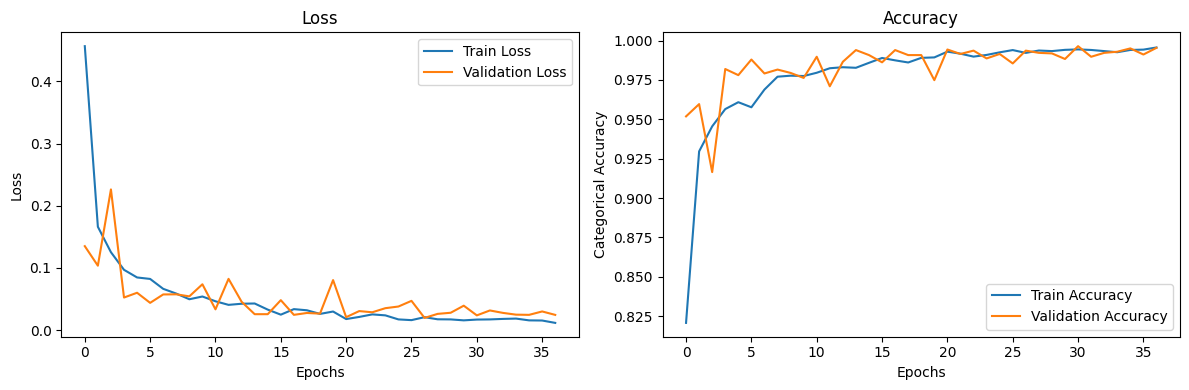

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('src/training_history.png')
plt.show()

## Evaluation

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9371 - categorical_accuracy: 0.8724 - loss: 0.4137 - precision: 0.8724 - recall: 0.8724
Test Loss: 0.8886449933052063
Test Precision: 0.7601103186607361
Test Recall: 0.7601103186607361
Test AUC: 0.8400667309761047
Test Accuracy: 0.7601103186607361
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

        fake       0.91      0.58      0.71       544
        real       0.69      0.94      0.80       544

    accuracy                           0.76      1088
   macro avg       0.80      0.76      0.75      1088
weighted avg       0.80      0.76      0.75      1088



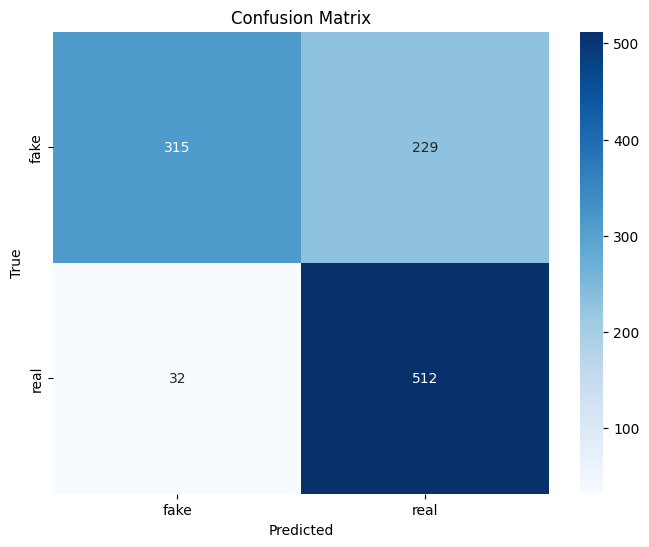

In [20]:
# Evaluating the model
test_loss, test_precision, test_recall, test_auc, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test Accuracy: {test_accuracy}")

# Generating predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generating classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Generating numerical confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Saving the Model

In [19]:
# Saving the model
model.save('model/final_model.h5')

# Saving the label encoder
joblib.dump(label_encoder, 'model/label_encoder.pkl')

# Saving the training history
with open('model/training_history.json', 'w') as f:
    json.dump(history.history, f)